<a href="https://colab.research.google.com/github/dbtjr1103/Basic_practice/blob/main/1_UNET_%EB%8F%99%EB%AC%BC_image_segmentation_basic_(%EC%9E%91%EC%84%B1%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## 환경 설정

In [1]:
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 KB 1.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
from IPython.display import Image, display
from PIL import ImageOps
from matplotlib import pyplot as plt

from keras_unet_collection import models, base, utils
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max

In [3]:
from tensorflow.python.client import device_lib
for dev in device_lib.list_local_devices():
    print(dev.device_type, dev.memory_limit)
gpu_max_mem = float(device_lib.list_local_devices()[0].memory_limit)
gpu_mem_limit = 12
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1024*1024*1024*gpu_mem_limit/gpu_max_mem)
    )
sess = tf.compat.v1.Session(config=config)

CPU 268435456
GPU 14417788928


## Data 다운로드

In [4]:
#oxford pet data
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  13.2M      0  0:00:56  0:00:56 --:--:-- 13.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  4925k      0  0:00:03  0:00:03 --:--:-- 4924k


## 이미지 데이터 path 지정

In [5]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (128, 128)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:3], target_img_paths[:3]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png


## 학습 데이터 파악

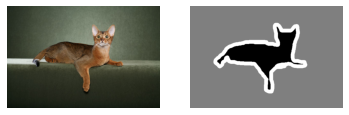

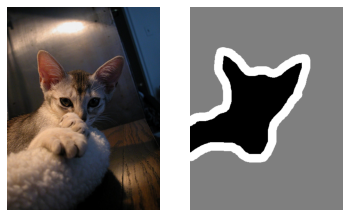

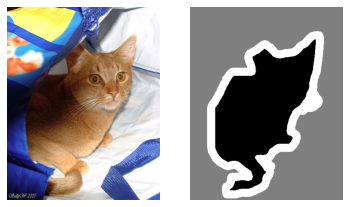

In [6]:
for img_idx in range(3):
    ori_img = load_img(input_img_paths[img_idx])
    target_img = ImageOps.autocontrast(load_img(target_img_paths[img_idx]))

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(ori_img)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(target_img, vmax = 3, vmin = 0)
    plt.show()

## 데이터로더 구성

In [7]:
class OxfordPetsData(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths


    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

            # target data에 있는 라벨인 1, 2, 3 에서 1을 빼서 0, 1, 2 로 변경
            y[j] -= 1
        return x, y


## 모델 구축

### U-Net 모델 1 - 절차형

In [ ]:
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)

### U-Net 모델 1 - 객체 지향형

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate

# 직접 따라해 봅시다!
""" Conv Block """
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(n_filters, 3, padding='same')
        self.conv2 = Conv2D(n_filters, 3, padding='same')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        self.activation = Activation('relu')
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x

""" Encoder Block """
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(EncoderBlock, self).__init__()

        self.conv_blk = ConvBlock(n_filters)
        self.pool = MaxPooling2D((2,2))

    def call(self, inputs):
        x = self.conv_blk(inputs)
        p = self.pool(x)
        return x,p

""" Decoder Block """
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(DecoderBlock, self).__init__()

        self.up = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')
        self.conv_blk = ConvBlock(n_filters)

    def call(self, inputs, skip):
        x = self.up(inputs)
        x = Concatenate()([x, skip])
        x = self.conv_blk(x)

        return x

""" U-Net Model """
class UNET(tf.keras.Model):
    def __init__(self, n_classes):
        super(UNET, self).__init__()

        # Encoder
        self.e1 = EncoderBlock(64)
        self.e2 = EncoderBlock(128)
        self.e3 = EncoderBlock(256)
        self.e4 = EncoderBlock(512)

        # Bridge
        self.b = ConvBlock(1024)

        # Decoder
        self.d1 = DecoderBlock(512)
        self.d2 = DecoderBlock(256)
        self.d3 = DecoderBlock(128)
        self.d4 = DecoderBlock(64)

        # Outputs
        if n_classes == 1:
            activation = 'sigmoid'
        else:
            activation = 'softmax'

        self.outputs = Conv2D(n_classes, 1, padding='same', activation = activation)
    
    def call(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        outputs = self.outputs(d4)

        return outputs

keras.backend.clear_session()

model = UNET(num_classes)      


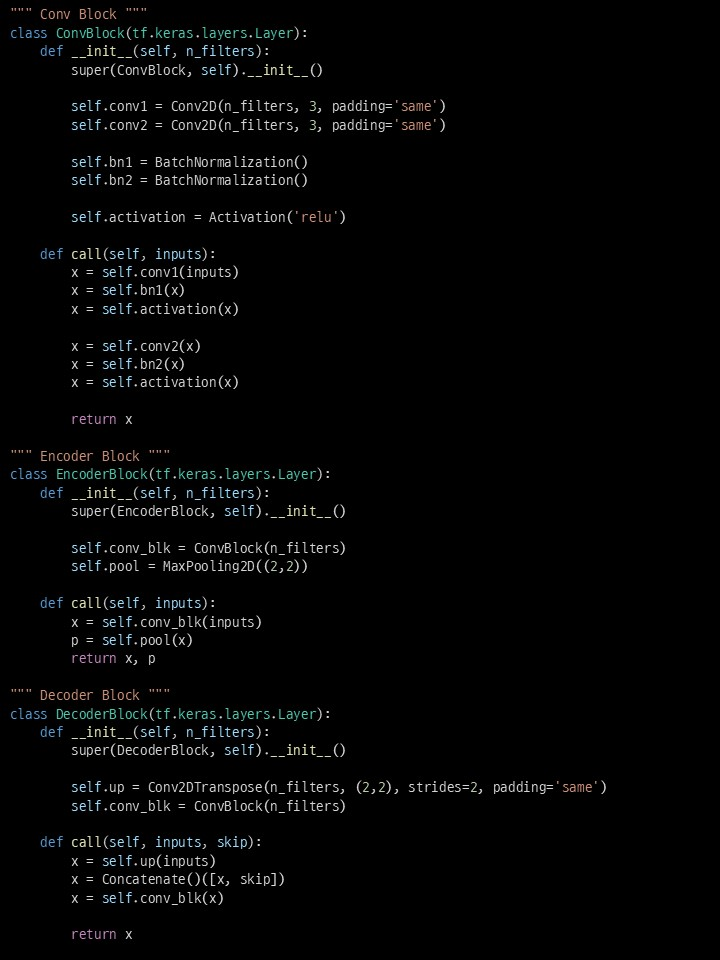

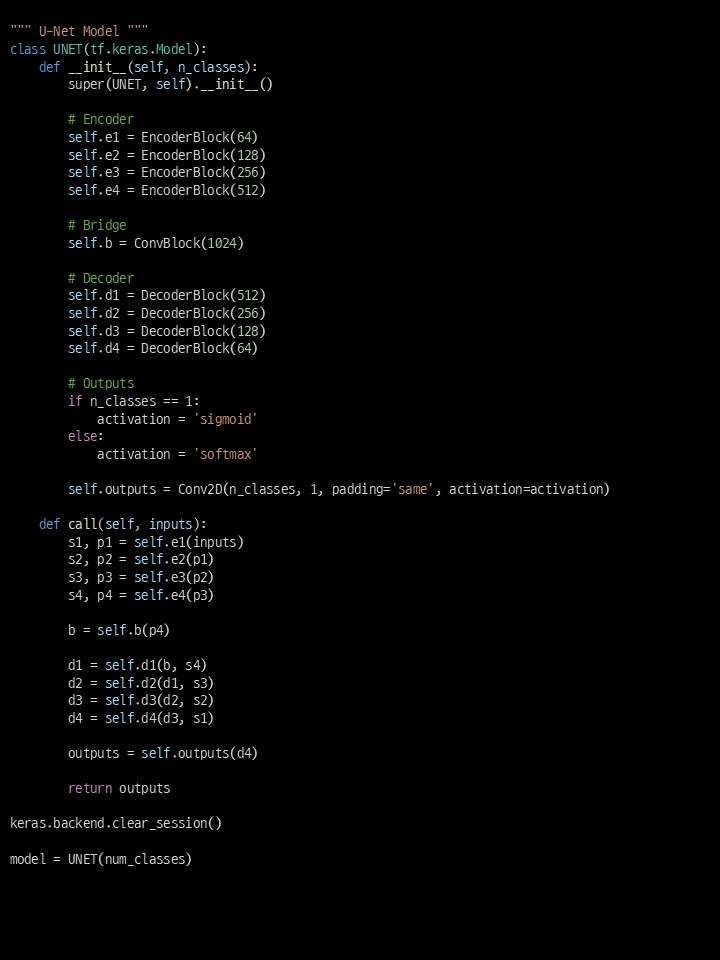

## 트레이닝 데이터 분할 및 데이터로더 생성

In [16]:
import random

# train, val split
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPetsData(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPetsData(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 학습

In [18]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

with tf.device("/device:GPU:0"):
    model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
199/199 [==============================] - 89s 437ms/step - loss: 0.5744 - val_loss: 3.0206
Epoch 2/10
199/199 [==============================] - 88s 441ms/step - loss: 0.4332 - val_loss: 0.7581
Epoch 3/10
199/199 [==============================] - 89s 445ms/step - loss: 0.3704 - val_loss: 0.5375
Epoch 4/10
199/199 [==============================] - 91s 454ms/step - loss: 0.3325 - val_loss: 0.4842
Epoch 5/10
 23/199 [==>...........................] - ETA: 1:13 - loss: 0.3094

KeyboardInterrupt: ignored

In [12]:
model.summary()

Model: "unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block (EncoderBlock  multiple                 39232     
 )                                                               
                                                                 
 encoder_block_1 (EncoderBlo  multiple                 0 (unused)
 ck)                                                             
                                                                 
 encoder_block_2 (EncoderBlo  multiple                 0 (unused)
 ck)                                                             
                                                                 
 encoder_block_3 (EncoderBlo  multiple                 0 (unused)
 ck)                                                             
                                                                 
 conv_block_4 (ConvBlock)    multiple                  0 (unus

In [19]:
val_preds = model.predict(val_gen)
print(len(val_preds), val_preds[0].shape)

31/31 [==============================] - 6s 194ms/step
992 (128, 128, 3)


## 결과 시각화

In [20]:
from tensorflow.keras.preprocessing import image
import cv2

color_map = {
 '0': [255, 0, 0],
 '1': [0, 0, 0],
 '2': [255, 255, 255],
}

def resize_mask(img, target_size):
    mask = np.argmax(img, axis=-1)
    mask = tf.expand_dims(mask, axis=-1).numpy().astype(float)
    return cv2.resize(mask, dsize=target_size, interpolation=cv2.INTER_NEAREST)

def add_mask_to_img(input_img, mask, alpha = 0.6):
    img_color = image.img_to_array(input_img)
    img = image.img_to_array(input_img)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            img_color[i, j] = color_map[str(int(mask[i, j]))]
    
    alpha = 0.6
    img = cv2.addWeighted(img, alpha, img_color, 1-alpha, 0, img_color, dtype = cv2.CV_32F)
    return img

def ero_dil(im, filter_size = 5):
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (filter_size, filter_size))
    im = cv2.dilate(im, se) #팽창
    im = cv2.erode(im, se) #침식

    return im

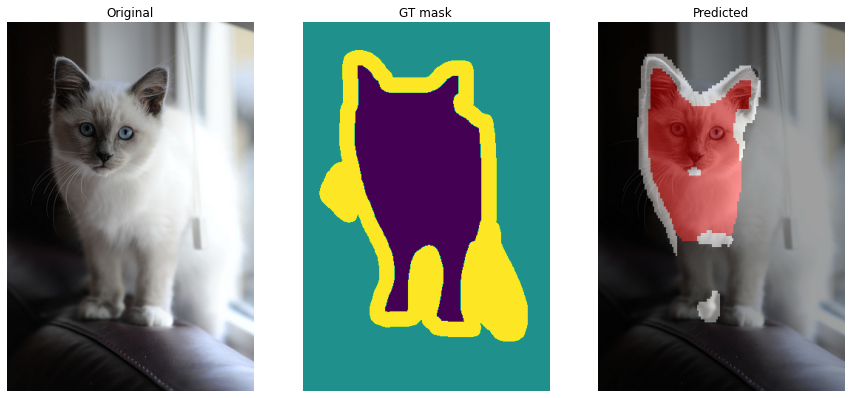

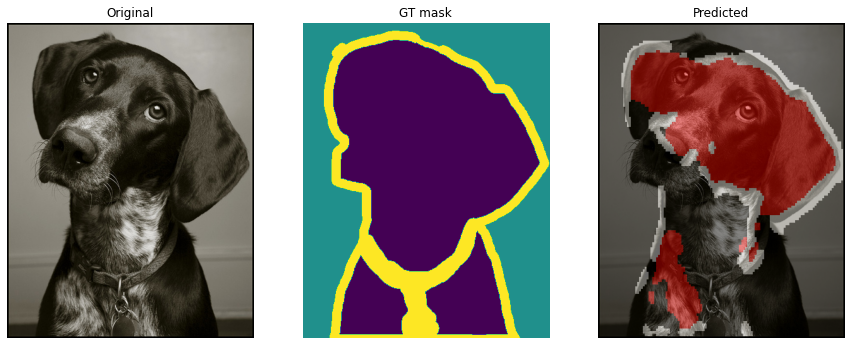

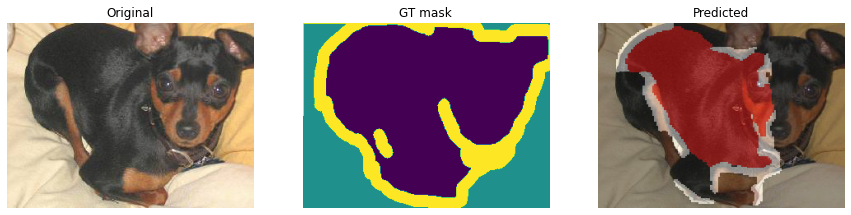

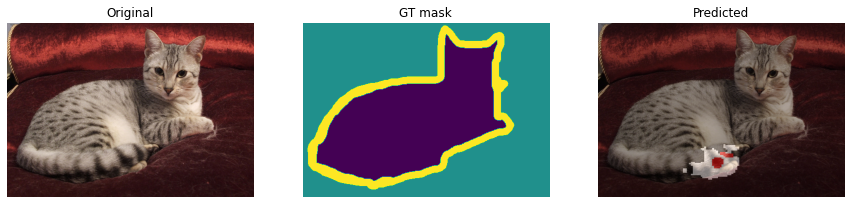

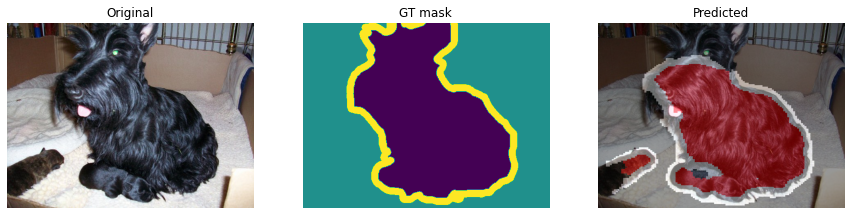

In [21]:
for img_idx in random.sample(list(range(len(val_preds))), 5):
    plt.figure(figsize=(15,8))

    ori_img = load_img(val_input_img_paths[img_idx])
    target_img = load_img(val_target_img_paths[img_idx])
    target_mask = image.img_to_array(target_img)[:,:,0] - 1
    
    mask = val_preds[img_idx]

    plt.subplot(1,3,1)
    plt.title('Original')
    plt.axis("off")
    plt.imshow(ori_img)
    
    plt.subplot(1,3,2)
    plt.title('GT mask')
    plt.axis("off")
    plt.imshow(target_mask)

    resized_mask = resize_mask(mask, ori_img.size)
    masked_img = add_mask_to_img(ori_img, resized_mask)

    plt.subplot(1,3,3)
    plt.title('Predicted')
    plt.axis("off")
    processed_mask = ero_dil(resized_mask)
    masked_img = add_mask_to_img(ori_img, processed_mask)
    plt.imshow(image.array_to_img(masked_img))

    plt.show()